<a href="https://colab.research.google.com/github/ipavlopoulos/modern_nlp/blob/main/ModernNLP_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModernNLP: #1
* Talk about word usage change and this recent [Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora](https://www.aclweb.org/anthology/2020.acl-main.51.pdf).
* As background, read Mikolov's [ICLR](https://research.google/pubs/pub41224/) and [NIPS](https://papers.nips.cc/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html) papers, and alingment models such as [Procrustes](https://www.aclweb.org/anthology/K18-1021.pdf) and [Compass](https://arxiv.org/abs/1906.02376).
* Whoever interested take a look [subword embeddings](https://www.aclweb.org/anthology/P16-1162.pdf). 
* Import Gensim's Word2Vec.

Adapted from:
```
John Pavlopoulos, Senior Lecturer (fixed-term) 
Stockholm University, Sweden
```

By:
```
Guilherme Dinis J., Phd Candidate
Stockholm University, Sweden
```




---



## Context

We are studying the method proposed by Gonen, et. al to measure word change usage between corpora, through their embeddings.
Their approach is based on comparing nearest neighbours - the hypothesis being that if words remain the same, their neighbors will also be the same, but if they change in usage, then so will their neighbours.

This notebook reprocuses the paper - with some deviations.

In [1]:
%%capture
from gensim.models import word2vec
from gensim import models
from gensim import corpora
import logging
import nltk
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk import tokenize
import multiprocessing as mp
from typing import List, Sequence, Mapping, Tuple, Any, Tuple, Optional, Text
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

import collections

In [2]:
Sentence = List[Text]

In [3]:
%matplotlib inline

In [4]:
nltk.download('brown')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [5]:
len(set(brown.words()))

56057

In [6]:
print(brown.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


In [7]:
class Corpus:
    def __init__(self, sents: List[Sentence], words: List[Text]):
        self._sents = sents
        self._words = words
        self._word_frequency = collections.Counter(words)
    
    def sents(self):
        return self._sents

    def words(self):
        return self._words

    def frequency(self, word: str) -> Optional[int]:
        try:
            return self._word_frequency[word]
        except KeyError:
            return None

    def word_frequency(self) -> collections.Counter:
        return self._word_frequency

In [8]:
def process_sentences(sents: List[Sentence], stop_words: Sequence[Text], tokenizer: Any) -> List[Sentence]:
    new_sents = []
    # filter stop words
    for sentence in sents:
        new_sentence = [term for term in sentence if term not in stop_words]
        new_sentence = tokenizer.tokenize_sents(new_sentence)
        new_sentence = [terms[0] for terms in new_sentence if terms]
        if new_sentence:
            new_sents.append(new_sentence)
    return new_sents

def process_words(words: List[Text], stop_words: Sequence[Text], tokenizer: Any) -> List[Sentence]:
    new_words = [term for term in words if term not in stop_words]
    new_words = [tokenizer.tokenize(term) for term in new_words]
    new_words = [term for terms in new_words for term in terms]
    return new_words
    
    
def nlp_pipeline(sents: List[Sentence], words: List[Text], strict_rules: bool) -> Corpus:
    stop_words = set(stopwords.words("english"))
    tokenizer = tokenize.RegexpTokenizer(r'\w+')
    new_sents = process_sentences(sents, stop_words, tokenizer)
    new_words = process_words(words, stop_words, tokenizer)
    
    if strict_rules:
        # filter most and least frequent 200 words
        # neighbors must have frequency of 100        
        limit = 200
        min_count = 100
    else:
        limit = 50
        min_count = 50

    counter = collections.Counter(new_words)
    most_common_words = set([w for w, _ in counter.most_common()[:limit]])
    least_common_words = set([w for w, _ in counter.most_common()[-limit:]])
    def valid(term):
        return term not in most_common_words and term not in least_common_words and counter[term] >= min_count
    
    for i in range(len(new_sents)):
        new_sents[i] = [term for term in new_sents[i] if valid(term)]
    # remove empty ones.
    new_sents = [sentence for sentence in new_sents if sentence]
    new_words = [term for term in new_words if valid(term)]
    return Corpus(new_sents, new_words)
    


In [9]:
browns_corpus = nlp_pipeline(brown.sents(), brown.words(), strict_rules=False)

In [10]:
print(browns_corpus.sents()[0], "\n", browns_corpus.words()[0])

['County', 'Friday', 'recent', 'primary', 'election', 'produced', 'evidence', 'took', 'place'] 
 County


In [11]:
def generate_embeddings(
    sentences: List[Sentence], num_spaces: int, vector_size: int = 100, negative: int = 5, min_count: int = 20
) -> List[Any]:
    spaces = []
    # different spaces
    for i in range(num_spaces):
        space = word2vec.Word2Vec(
            sentences, vector_size=vector_size, negative=negative, 
            min_count=min_count, seed=i, workers=mp.cpu_count()
        )
        spaces.append(space)
    return spaces

In [12]:
def word_neighbors(
  target: Text, topn: int, spaces: List[word2vec.Word2Vec]
) -> Mapping[int, Sequence[Tuple[str, float]]]:
    # the neighbors
    neighbors = {}
    for i, space in enumerate(spaces):
        neighbors[i] = space.wv.most_similar(positive=[target], topn=topn)
    return neighbors

In [13]:
def create_word_frequency(words: List[str]) -> corpora.Dictionary:
    return collections.Counter(words)

In [14]:
spaces = generate_embeddings(sentences=browns_corpus.sents(), num_spaces=10)

In [15]:
def neighbour_overlap(v1, v2):
    """Overlap between two lists. Each element is a 2-tuple of (word, score)."""
    assert len(v1) == len(v2)
    pool = set([word for word, _ in v2])
    return len([1 for (w1, _), _ in zip(v1, v2) if w1 in pool])/len(v1)

def score(v1, v2):
    assert len(v1) == len(v2)
    pool = set([word for word, _ in v2])
    return -len([1 for (w1, _), _ in zip(v1, v2) if w1 in pool])


def vocabulary_overlap(neighbors: Mapping[int, Sequence[Tuple[Text, float]]], minn: int, maxn: int) -> List[float]:
    """
    Computes the overlap between sets of neibhors.
    The number of neihbors used varies from minn to maxn.
    """
    mean_overlaps = []
    all_overlaps = {}
    
    for n in range(minn, maxn + 1):
        # compute similarities
        for i in range(len(neighbors)):
            for j in range(len(neighbors)):
                if i < j: 
                    # compare only the top n items in the lists
                    overlap = neighbour_overlap(neighbors[i][:n], neighbors[j][:n])
                    all_overlaps[(i, j)] = overlap
                    all_overlaps[(j, i)] = overlap
        overlaps = []
        for i in range(len(neighbors)):  
            ij_overlaps = []
            for j in range(len(neighbors)):
                if i != j:
                    ij_overlaps.append(all_overlaps[(i, j)])
            overlaps.append(np.mean(ij_overlaps))
        mean_overlaps.append(np.mean(overlaps))
    return mean_overlaps



In [16]:
def plot_and_show_overlaps(word: Text, spaces: List[Any], topn: int, minn: int, maxn: int) -> None:
    neighbors = word_neighbors(target=word, topn=topn, spaces=spaces)
    mean_overlaps = vocabulary_overlap(neighbors, minn=minn, maxn=maxn)

    # Plot the mean relative overlap of a word with its self (self-similarity), 
    # for a varying number of neighbors.
    pd.DataFrame({"self similariry": mean_overlaps}).plot();
    top10 = pd.DataFrame({i:[n[0] for n in neighbors[i][:10]] for i in neighbors})
    top10.head()



In [17]:
browns_corpus.word_frequency().most_common()[:2], browns_corpus.word_frequency().most_common()[-2:]

([('see', 730), ('get', 722)], [('Have', 50), ('Linda', 50)])

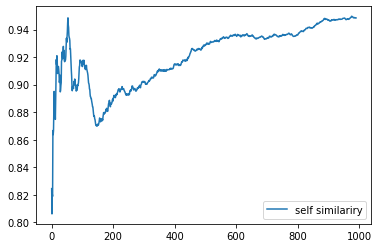

In [18]:
plot_and_show_overlaps(word="left", spaces=spaces, topn=1000, minn=10, maxn=1000)

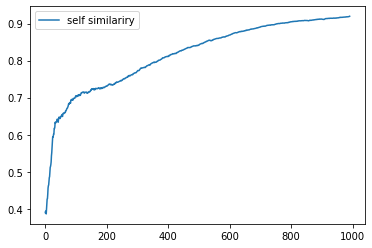

In [19]:
plot_and_show_overlaps(word="religion", spaces=spaces, topn=1000, minn=10, maxn=1000)

In [20]:
# get the mean overlap for top K NN, for a set of words
def words_nn_overlaps(words: List[Text], spaces: List[Any], topn: int, minn: int, maxn: int) -> List[List[float]]:
    results = []
    for word in words:
        neighbors = word_neighbors(target=word, topn=topn, spaces=spaces)
        mean_overlaps = vocabulary_overlap(neighbors, minn=minn, maxn=maxn)
        results.append(mean_overlaps)
    return results

In [21]:
# plot the mean overlap for a set of words
def plot_words_nn_overlaps(words: List[Text], words_overlaps: List[List[float]]) -> Any:
    fig, ax = plt.subplots(figsize=(12, 8))
    for word, overlaps in zip(words, words_overlaps):
        plt.plot(overlaps, label=word)
    ax.set_title("Word Overlaps")
    ax.legend()


## Comparing Frequent, Infrequent, and Middle Words

In [22]:
word_counts = np.array([count for _, count in browns_corpus.word_frequency().items()])

In [23]:
word_counts.max(), word_counts.min()

(730, 50)

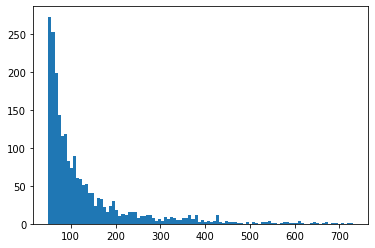

In [24]:
_ = plt.hist(word_counts, bins=100)

In [25]:
def compute_and_plot_overlaps(words: List[Text], spaces: List[Any], topn: int, minn: int, maxn: int):
    overlaps = words_nn_overlaps(
        words, spaces=spaces, topn=topn, minn=minn, maxn=maxn
    )
    plot_words_nn_overlaps(words=words, words_overlaps=overlaps)

In [26]:
def get_word_counts(word_frequency: collections.Counter, n: int, mode: str, min_count: int):
    if mode == "head":
        return [(word, count) for word, count in word_frequency.most_common()[:n] if count >= min_count]
    elif mode == "tail":
        results = []
        for word, count in reversed(word_frequency.most_common()):
            if count >= min_count:
                results.append((word, count))
            if len(results) >= n:
                break
        return results
    elif mode == "middle":
        results = []
        # filter min count first
        most_common = [(word, count) for word, count in word_frequency.most_common() if count >= min_count]
        unique_frequency = sorted(set([count for _, count in most_common]))
        mid_value_index = int(len(unique_frequency) * 0.5)
        start_index = int(mid_value_index - n / 2)
        mid_values = [unique_frequency[i] for i in range(start_index, start_index + n)]
        # find words with mid_values count
        for mid_value in mid_values:
            for i in range(len(most_common)):
                word, count = most_common[i]
                if count == mid_value:
                    results.append((word, count))
                    break
        return results


### Frequent Terms

In [27]:
most_frequent_words_count = get_word_counts(browns_corpus.word_frequency(), n=10, mode="head", min_count=10)
most_frequent_words = [word for word, _ in most_frequent_words_count]

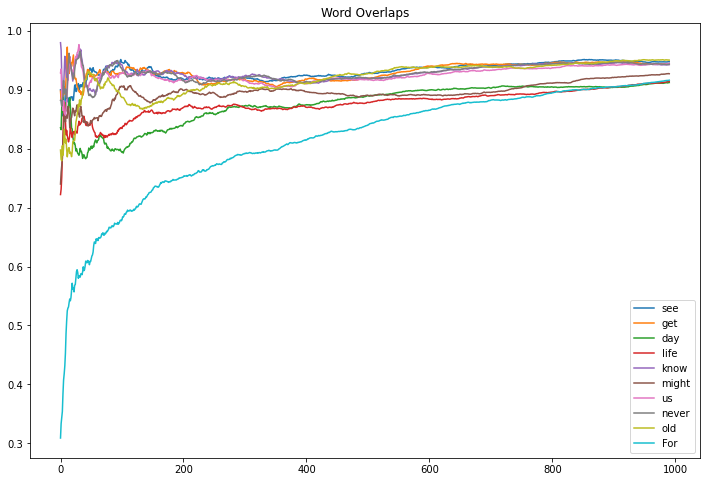

In [28]:
compute_and_plot_overlaps(most_frequent_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

### Infrequent Terms

In [29]:
least_frequent_words_count = get_word_counts(browns_corpus.word_frequency(), n=10, mode="tail", min_count=10)
least_frequent_words = [word for word, _ in least_frequent_words_count]

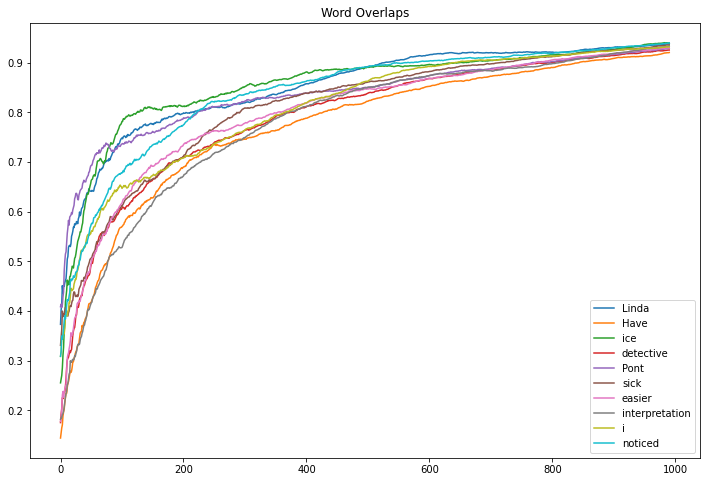

In [30]:
compute_and_plot_overlaps(least_frequent_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

### Middle Terms

In [31]:
middle_words_count = get_word_counts(browns_corpus.word_frequency(), n=10, mode="middle", min_count=10)
middle_words = [word for word, _ in middle_words_count]

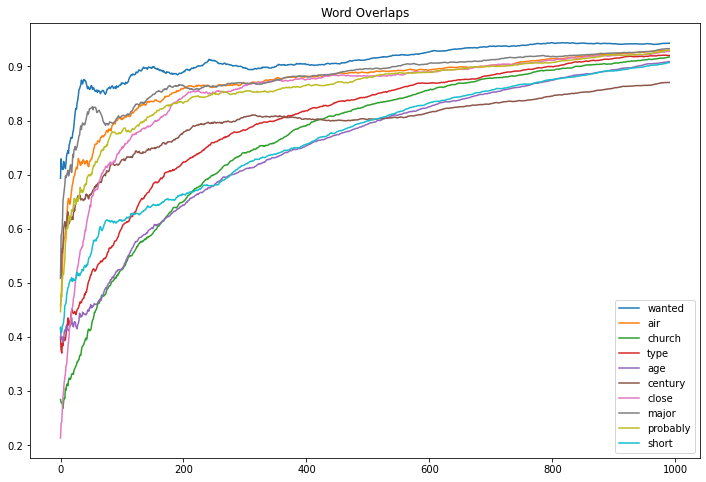

In [32]:
compute_and_plot_overlaps(middle_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

In [33]:
middle_words_count

[('wanted', 226),
 ('air', 227),
 ('church', 228),
 ('type', 229),
 ('age', 230),
 ('century', 232),
 ('close', 233),
 ('major', 235),
 ('probably', 236),
 ('short', 238)]

On principle, rare terms are sporadic, and so they can possibly occur next to dissimilar terms - i.e. their neighours may not repeat. Frequent terms, on the other hand, would have a higher pool of words they appear next to, but some of those words might be more consistent (frequent) than others.
The middle ones would have a combination of these two properties.


Because we are comparing the same corpus here, what we would expect to observe if we simply counted the occurence of the neighbours is that the top K neighbours for infrequent and highly frequent terms should be the same.
For infrequent terms, some words might only appear once next to two other words - the other words at distance > 1 would would only have a frequency of 1 for the rarest of words. (W2V ran with a limit of 1 occurence).

Since we're using embeddings, these low frequency terms will have fewer (gradient) updates - so our estimates of their consine distance to other terms should be less certain - hence, we can easily find lower overlap across embeddings.
In our plots, we're using words that appear at least 10 times.

The paper notes that the more neighbours used, the more "stable" the similarity is between neighbours.
However, there is another factor at play here: term frequency.

**Scenario One: Strict Filtering**
In this scenario, we observe the processing rules of the paper, which remove terms with frequency bellow 100, as well as the head and tail 200 terms

Very frequent words have higher overlap at low values of K - an overlap that first decreases as K increases, before increasing again.
Overall, highly frequency, low frequency and mid frequency terms roughly have the same patter - relatively stable increase in overlap as a result of increasing K.

**Scenario Two: Relaxed Filtering**
In this scenario, we only remove stop words and terms with frequency below 10.
What we observe is that very frequent words have higher overlap at low values of K, and these terms include supporting words (e.g. from, the) - and overlap that first decreases as K increases.
Before decreasing, the overlap also increases slightly for standard words - possibly due to other high frequency words appearing in the comparative set.
The variacne in overlap is reflected more for mid frequency terms. 
When comparing them on the same corpus, the overlap for these terms can be a hit or miss since they can have a bigger pool of possible NN - and which ones end up closest will depend on other factors (e.g. network initialization).
The infrequent words, on the other hand, show the opposite behavior - their rarity means that they can appear next to diverse terms, and at a low count.
So in terms of pair frequency, there can be a few terms considered NN, and with a small frequency, i.e. [(a, b), 1].
In terms of data for learning representations, we can expect higher changes in the position of words in the embeddings space across trainings.




The question is: for corpora where usage has actually changed, what would we observe?

## Comparing Different Corpora

In [34]:
from nltk.corpus import comtrans

In [35]:
comtrans_corpus = nlp_pipeline(comtrans.sents(), comtrans.words(), strict_rules=False)

In [36]:
cmrw = set(comtrans_corpus.words())
for token, count in middle_words_count:
    print(f"{token}({count}) is present in Reviews: {token in cmrw}, count - {comtrans_corpus.frequency(token)}")
    

wanted(226) is present in Reviews: True, count - 53
air(227) is present in Reviews: True, count - 60
church(228) is present in Reviews: False, count - 0
type(229) is present in Reviews: True, count - 110
age(230) is present in Reviews: True, count - 51
century(232) is present in Reviews: True, count - 59
close(233) is present in Reviews: True, count - 81
major(235) is present in Reviews: True, count - 175
probably(236) is present in Reviews: True, count - 72
short(238) is present in Reviews: True, count - 114


In [37]:
comtrans_spaces = generate_embeddings(sentences=comtrans_corpus.sents(), num_spaces=1)

In [38]:
pd.DataFrame(
    word_neighbors(target="major", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(programs, 0.9960622191429138)","(among, 0.9935801029205322)"
1,"(administration, 0.9933848977088928)","(actually, 0.9934940338134766)"
2,"(plan, 0.9925823211669922)","(face, 0.9932726621627808)"
3,"(service, 0.9925375580787659)","(key, 0.9927231669425964)"
4,"(business, 0.9918382167816162)","(matters, 0.9923380017280579)"
5,"(defense, 0.9914964437484741)","(general, 0.992264449596405)"
6,"(research, 0.9913620352745056)","(comes, 0.9918939471244812)"
7,"(industry, 0.9913051724433899)","(priority, 0.9917864203453064)"
8,"(aid, 0.9911433458328247)","(importance, 0.9916744828224182)"
9,"(support, 0.990846574306488)","(parties, 0.9915812611579895)"


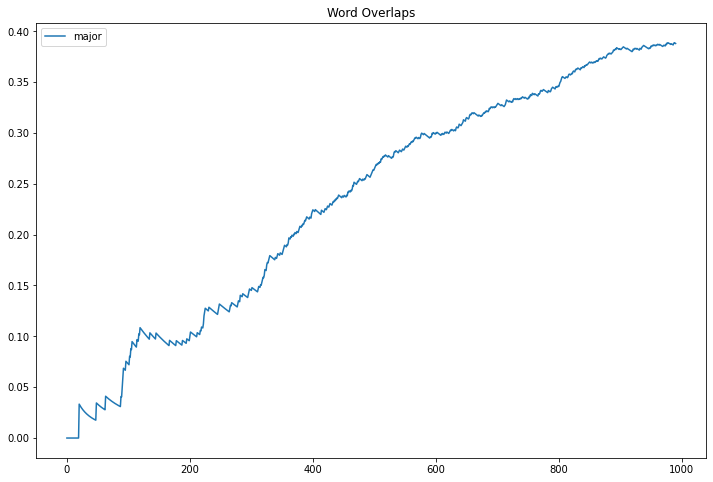

In [39]:
compute_and_plot_overlaps(["major"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

In [40]:
pd.DataFrame(
    word_neighbors(target="century", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(Boston, 0.9922520518302917)","(How, 0.9917464852333069)"
1,"(famous, 0.9918875098228455)","(American, 0.9913663268089294)"
2,"(offered, 0.9915249347686768)","(disaster, 0.9894737005233765)"
3,"(club, 0.9908725023269653)","(caused, 0.989219605922699)"
4,"(book, 0.9907678961753845)","(long, 0.9891108274459839)"
5,"(battle, 0.9906622767448425)","(short, 0.9885929822921753)"
6,"(Old, 0.9906260967254639)","(despite, 0.9884077906608582)"
7,"(Hudson, 0.9904554486274719)","(highly, 0.9882158041000366)"
8,"(nineteenth, 0.990146815776825)","(building, 0.9878792762756348)"
9,"(whose, 0.9899981021881104)","(analysis, 0.987790584564209)"


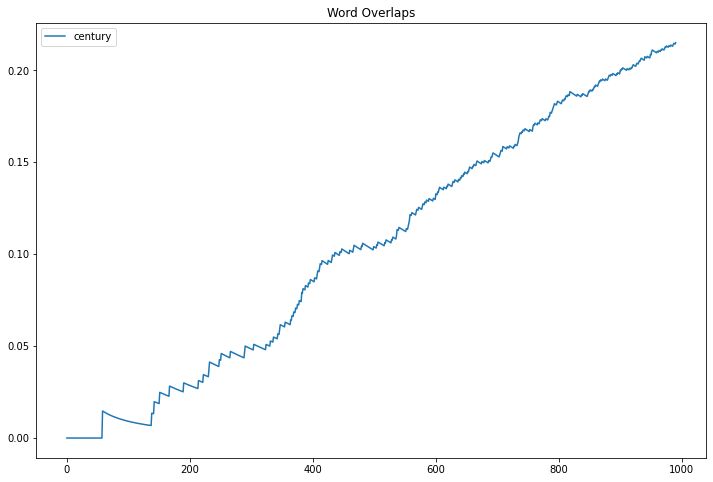

In [41]:
compute_and_plot_overlaps(["century"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

In [42]:
pd.DataFrame(
    word_neighbors(target="short", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(moon, 0.9964996576309204)","(reality, 0.9939665198326111)"
1,"(wide, 0.9961858987808228)","(manner, 0.9939600229263306)"
2,"(clay, 0.9959894418716431)","(find, 0.9939218759536743)"
3,"(wave, 0.9957391023635864)","(happen, 0.9937069416046143)"
4,"(slow, 0.995598554611206)","(rather, 0.993698239326477)"
5,"(sides, 0.9955357909202576)","(turn, 0.9934127330780029)"
6,"(distance, 0.9955356121063232)","(enough, 0.9933395385742188)"
7,"(depth, 0.9954175353050232)","(never, 0.9932268857955933)"
8,"(metal, 0.995332658290863)","(fear, 0.9927629232406616)"
9,"(heat, 0.9953138828277588)","(left, 0.9926834106445312)"


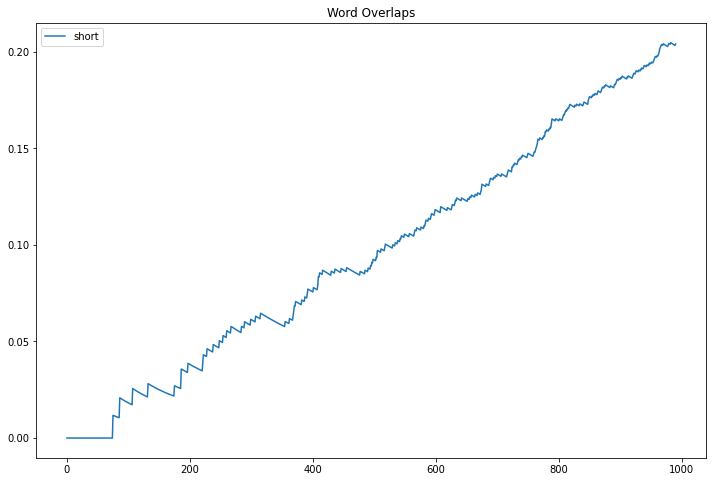

In [43]:
compute_and_plot_overlaps(["short"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

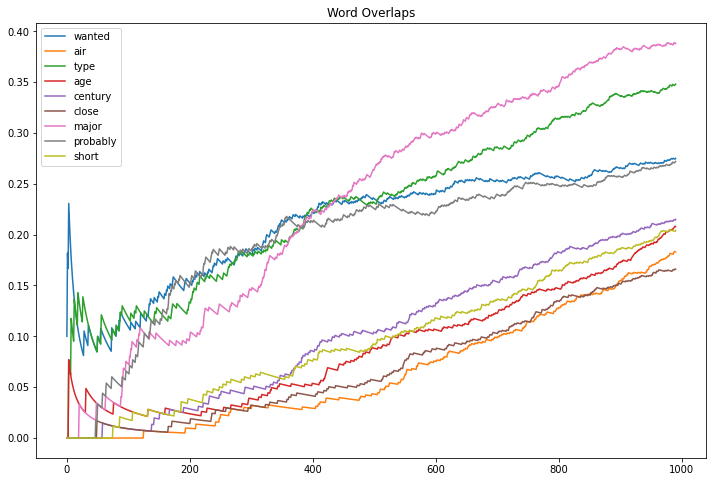

In [44]:
compute_and_plot_overlaps([word for word in middle_words if word in cmrw], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

We can see how relative term frequency plays a role here as well.

For every scenario - similar/increased/decreased word absolute frequency - the pattern differs at low values of K, but shows the trend of going from low overlap to an increase in overlap - even for tokens with virtually no overlap at low values of K.

This indicates that increasing K simply answers the question - how much overlap between tokens exists in the corpora?


Inspecting the NN in the three cases, we see dissimilarity. But it is difficult to judge without comparing other NN words - especially for terms with a high count of neighours having moderate frequency each in the corpus, which can have several potential candidate NN whose promximity will vary slightly (e.g. due to noise in generating the embeddings) - the NN scores are very close for many terms.

The differences lie at the smaller K:

  - Words infrequent in one set will have low overlap (at lower K).
  - Words moderately or highly frequent on both sets will have higher overlap (at lower K).




Determing if a word's usage is the same would, in theory from the NN principle, imply that the word would have to share the same neighbours - and the occurence of the word and its neighbours ought to be relatively the same between corpora.
But as we have seen, both rare and high frequency can be misinterpreted - the former
because of label bias and the latter for having a larger pool of "NN" in the embedding space.
It would be interesting to study how the change in the frequency use of a neighbour would affect the overlap of a
word under consideration; and how the method behaves when actual word frequencies are used instead of embeddings (i.e. counting neighbors to determine NN).

These observations raise one question:

  - For the tasks that are concerned with usage change (e.g. social science studies, as mentioned in the paper), is this definition of word usage change satisfactory - considering the change in frequency of word's neighbour can affect it's own standing in the embedding space?

In summary:

  - With this method, frequency of terms (and their neighbours) appears to have a very high impact on overlap - so usage change as defined here is a factor of neighbours and frequency.
  - Overlap might not even hold for the same words across embeddings due to randomization, and frequency of other terms in the dataset
  - At low values of K, a mid word can have too high of a candidate pool to determine their NN consistenly across embeddings from the same corpus - perhaps a more strict approach would offer stability (e.g. learn which word preceds and follows, instead of using a larger window), but it would likely bring other limitations.
  - The stability of overlap that is observed at very large K is likely due to overlap between terms in the corpus - hence not indicative of stability of the method itself.
